# Applying SDDR to KORA_S3_S4

We start by importing the sddr module and other required libraries:

In [1]:
import torch.nn as nn
import pandas as pd
import torch.optim as optim
from sddr import Sddr
from sklearn.model_selection import train_test_split
import inspect
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["CUDA_VISIBLE_DEVICES"]=""

### User inputs 

First the user defines the data to be used:

In [14]:
# define data location and read data into pandas dataframe
data_path = '../../../Data/KORA_S3_S4/KORA_Noise_noMissing_median.csv'
KORA_Noise_noMissing = pd.read_csv(data_path)

data = KORA_Noise_noMissing[['sex', 'age', 'bmi', 'smoking', 'lden_org']]
# print(data.head())
# print(data.describe())
X_mini_test = data['lden_org']
X_mini_test[X_mini_test<=40] = 40
data['lden_org'] = X_mini_test

target = KORA_Noise_noMissing[['bp_syst']]
# print(target.head())
# print(target.describe())

# split the data into train and test to use later for predictions
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.2)


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-14-fa96dfeffb1b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lden_org'] = X_mini_test


Next the distribution, formulas and training parameters are defined.

In [15]:
# define distribution and the formula for the distibutional parameter
# The degrees-of-freedom df here correspond to the degree
# of the B-spline. The degrees-of-freedom for each effect can be specified separately in the
# training_parameters argument of Sddr.

distribution  = 'Normal'
formulas = {'loc': '~ 1+ sex + smoking + spline(age, bs="bs",df=5)+spline(bmi, bs="bs",df=5)+ spline(lden_org, bs="bs",df=5)+d1(age)+ d3(lden_org)+d2(bmi)',
            'scale': '~ 1+ sex + smoking + spline(age, bs="bs",df=5)+spline(bmi, bs="bs",df=5)+ spline(lden_org, bs="bs",df=5)+d1(age)+ d3(lden_org)+d2(bmi)'}

# define the deep neural networks' architectures and output shapes used in the above formula
deep_models_dict = {
'd1': {
    'model': nn.Sequential(nn.Linear(1,15)),
    'output_shape': 15},
'd2': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8},
'd3': {
    'model': nn.Sequential(nn.Linear(1,3),nn.ReLU(), nn.Linear(3,8)),
    'output_shape': 8}
}

# define your training hyperparameters
train_parameters = {
    'batch_size': 1000,
    'epochs': 200,
    'degrees_of_freedom': {'loc': [3,3,3], 'scale':[3,3,3]},
    'optimizer' : optim.RMSprop,
    'val_split': 0.1
    }

# define output directory
output_dir = './outputs'

### Initialization

The sddr instance is initialized with the parameters given by the user in the previous step:

In [16]:
sddr = Sddr(distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters,
            output_dir=output_dir)

Using device:  cpu


### Training

The sddr network is trained with the data defined above and the loss curve is plotted. Note that in this example we only have tabular data so unstructured_data is not given.

Beginning training ...
Train Epoch: 0 	 Training Loss: 5159.427874
Train Epoch: 0 	 Validation Loss: 2180.688721
Train Epoch: 20 	 Training Loss: 159.220027
Train Epoch: 20 	 Validation Loss: 155.550156
Train Epoch: 40 	 Training Loss: 64.493567
Train Epoch: 40 	 Validation Loss: 63.568054
Train Epoch: 60 	 Training Loss: 32.849208
Train Epoch: 60 	 Validation Loss: 32.578766
Train Epoch: 80 	 Training Loss: 19.413919
Train Epoch: 80 	 Validation Loss: 19.182297
Train Epoch: 100 	 Training Loss: 12.934154
Train Epoch: 100 	 Validation Loss: 13.021148
Train Epoch: 120 	 Training Loss: 9.915859
Train Epoch: 120 	 Validation Loss: 9.776692
Train Epoch: 140 	 Training Loss: 8.965965
Train Epoch: 140 	 Validation Loss: 8.722451
Train Epoch: 160 	 Training Loss: 7.863170
Train Epoch: 160 	 Validation Loss: 7.832532
Train Epoch: 180 	 Training Loss: 7.726600
Train Epoch: 180 	 Validation Loss: 7.649969


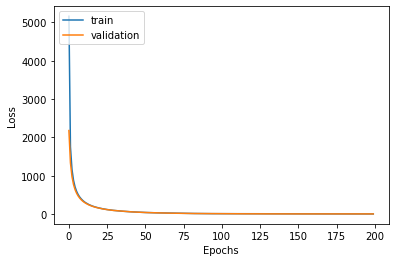

In [17]:
sddr.train(structured_data=train_data, target=train_target, plot=True)

### Visualizing the partial effects

The partial effects are computed by: partial effect = smooth_features * coefs (weights)
In other words the smoothing terms are multiplied with the weights of the Structured Head. We use the partial effects to interpret whether our model has learned correctly.

In the case below the model is a generalized additive model with two splines (one has a quadratic effect, one has only a linear effect), while target is assumed to come from a Poisson distribution. The quadratic and linear effects are confirmed when plotting the partial effects below.

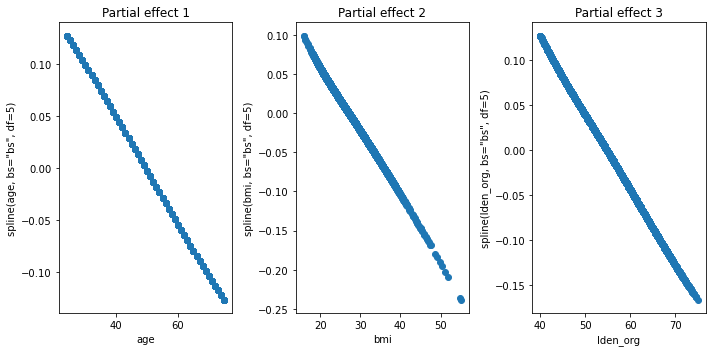

In [18]:
partial_effects = sddr.eval('loc')

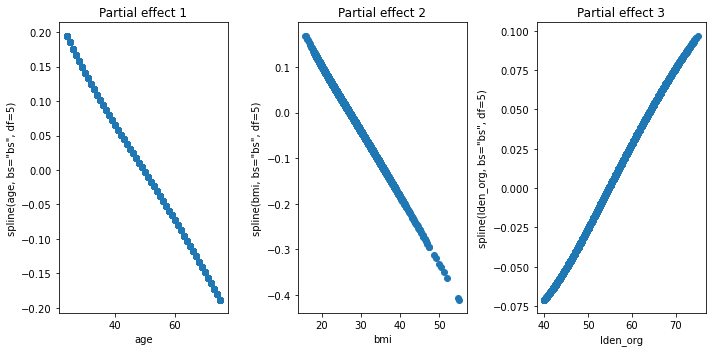

In [19]:
partial_effects = sddr.eval('scale')

### Save, load and resume

Next, we save the trained model. Along with the model's weights, the optimizer current state will be saved, along with the number of epochs we trained for and the final loss function

In [21]:
sddr.save('model_gam.pth')

<ipython-input-21-38575ea38e67>:1: UserWarning: Please note that the metadata for the structured input has not been saved. If you want to load the model and use
        it on new data you will need to also give the structured data used for training as input to the load function.
  sddr.save('model_gam.pth')


To resume training at a later state we need to again initialize an sddr instance, load the previously trained model and resume training. Note that the ```resume=True``` flag needs to be set here when calling ```sddr.train```. Also note that here ```epochs``` is set to 300, while previously the network was trained for ```200``` epochs. This means that the model during resume will train for 300-200=100 epochs more

In [22]:
train_parameters['epochs'] = 300
sddr_resume = Sddr(output_dir=output_dir,
            distribution=distribution,
            formulas=formulas,
            deep_models_dict=deep_models_dict,
            train_parameters=train_parameters)
sddr_resume.load('./outputs/model_gam.pth', train_data)
sddr_resume.train(target=train_target, structured_data=train_data, resume=True)
loss_resume = sddr_resume.epoch_train_loss

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a validation loss of 7.6240
Beginning training ...
Train Epoch: 210 	 Training Loss: 7.491193
Train Epoch: 210 	 Validation Loss: 7.439186
Train Epoch: 240 	 Training Loss: 7.279324
Train Epoch: 240 	 Validation Loss: 7.276093
Train Epoch: 270 	 Training Loss: 6.650135
Train Epoch: 270 	 Validation Loss: 6.859723


### Predicting

A trained model can also be used for predictions on unseen data. Note that when loading the model the structured training data is required to compute the knots of the basis functions used for the smoothing terms. The final line in this cell is commented out as it would give an error if run. Why? Check out the explanation below!

In [23]:
# initialize
pred_sddr = Sddr(distribution=distribution,
                formulas=formulas,
                deep_models_dict=deep_models_dict,
                train_parameters=train_parameters,
                output_dir=output_dir)
# load trained model
pred_sddr.load('./outputs/model_gam.pth', train_data)
# make predictions
#_, partial_effects_loaded = pred_sddr.predict(test_data, plot=True)

Using device:  cpu
Loaded model ./outputs/model_gam.pth at epoch 200 with a validation loss of 7.6240


C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The above error occurs because the test data is outside the range of the training data. The framework can deal with this problem by allowing clipping of the test data. For clipping the corresponding parameter needs to be set to ```True``` when calling ```predict()```

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


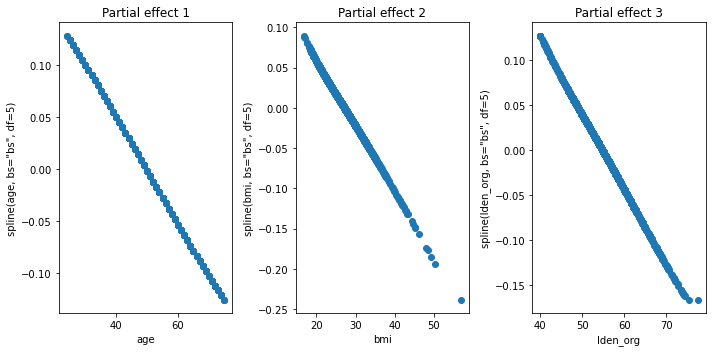

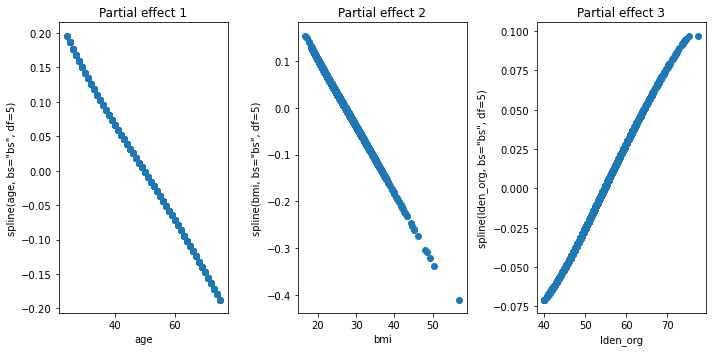

In [24]:
_, partial_effects_loaded = pred_sddr.predict(test_data, clipping=True, plot=True)

### Predicted Distribution

To get the distribution simply call:

In [25]:
distribution_layer = pred_sddr.get_distribution()

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


From there we can retrieve many of the distribution's properties. See some examples here:

In [26]:
mean = distribution_layer.mean
std = distribution_layer.stddev

C:\Users\sahar.behzadi\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
